In [66]:
import numpy as np
import pandas as pd
import torch
import torch.distributions as dist
from torch.distributions.mixture_same_family import MixtureSameFamily

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import beanmachine.ppl as bm
import beanmachine.ppl.experimental.inference_compilation.ic_infer as ic_infer

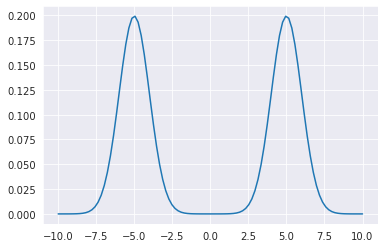

In [73]:
xs = torch.linspace(-10., 10.)
log_probs = torch.tensor([MixtureSameFamily(
    dist.Categorical(torch.ones(2,)),
    dist.Independent(
        dist.Normal(
            torch.tensor([[-5.], [5.]]),
            torch.tensor([[1.], [1.]]),
        ), 1)
).log_prob(x.unsqueeze(0)) for x in xs]).numpy()
plt.plot(xs, np.exp(log_probs))

In [74]:
@bm.random_variable
def y():
    return dist.Normal(0., 1.)

@bm.random_variable
def x():
    return MixtureSameFamily(
        dist.Categorical(torch.ones(2,)),
        dist.Independent(
            dist.Normal(
                torch.tensor([[-5.], [5.]]),
                torch.tensor([[1.], [1.]]),
            ), 1)
    )

In [87]:
queries = [x()]
obs = {y(): torch.tensor(1.0)}

ic = ic_infer.ICInference().compile(
    [y()],
    num_worlds=int(3e4),
    gmm_num_components=2,
)

results = dict()
for name, infer_instance in [
    ('IC', ic),
    ('RW', bm.SingleSiteRandomWalk()),
    #('NMC', bm.SingleSiteNewtonianMonteCarlo()),
    ('HMC', bm.SingleSiteHamiltonianMonteCarlo(path_length=10)),
    ('Ground Truth', bm.SingleSiteAncestralMetropolisHastings()),
]:
    results[name] = infer_instance.infer([x()], obs, num_samples=int(1e3), num_chains=1)

In [88]:
df = pd.DataFrame()
for name in results:
    trace = results[name][x()].squeeze().numpy()
    df = df.append(pd.DataFrame({
        'method': [name for _ in range(len(trace))],
        'x': trace,
    }))

In [92]:
import pickle
#pickle.dump(df, open("outputs/multimodal.pkl", "wb"))
df = pickle.load(open("outputs/multimodal.pkl", "rb"))

In [97]:
import scipy.stats
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
})

x = np.linspace(-10, 10)
y = np.linspace(-10, 10)
xx, yy = np.meshgrid(x, y)

c0 = scipy.stats.multivariate_normal(mean=[-5,0], cov=1)
c1 = scipy.stats.multivariate_normal(mean=[5,0], cov=1)

@np.vectorize
def gmm_pdf(x, y):    
    p = [x,y]
    return .5*c0.pdf(p) + .5*c1.pdf(p)

z = gmm_pdf(xx, yy)
z_posterior = gmm_pdf(x, [0])

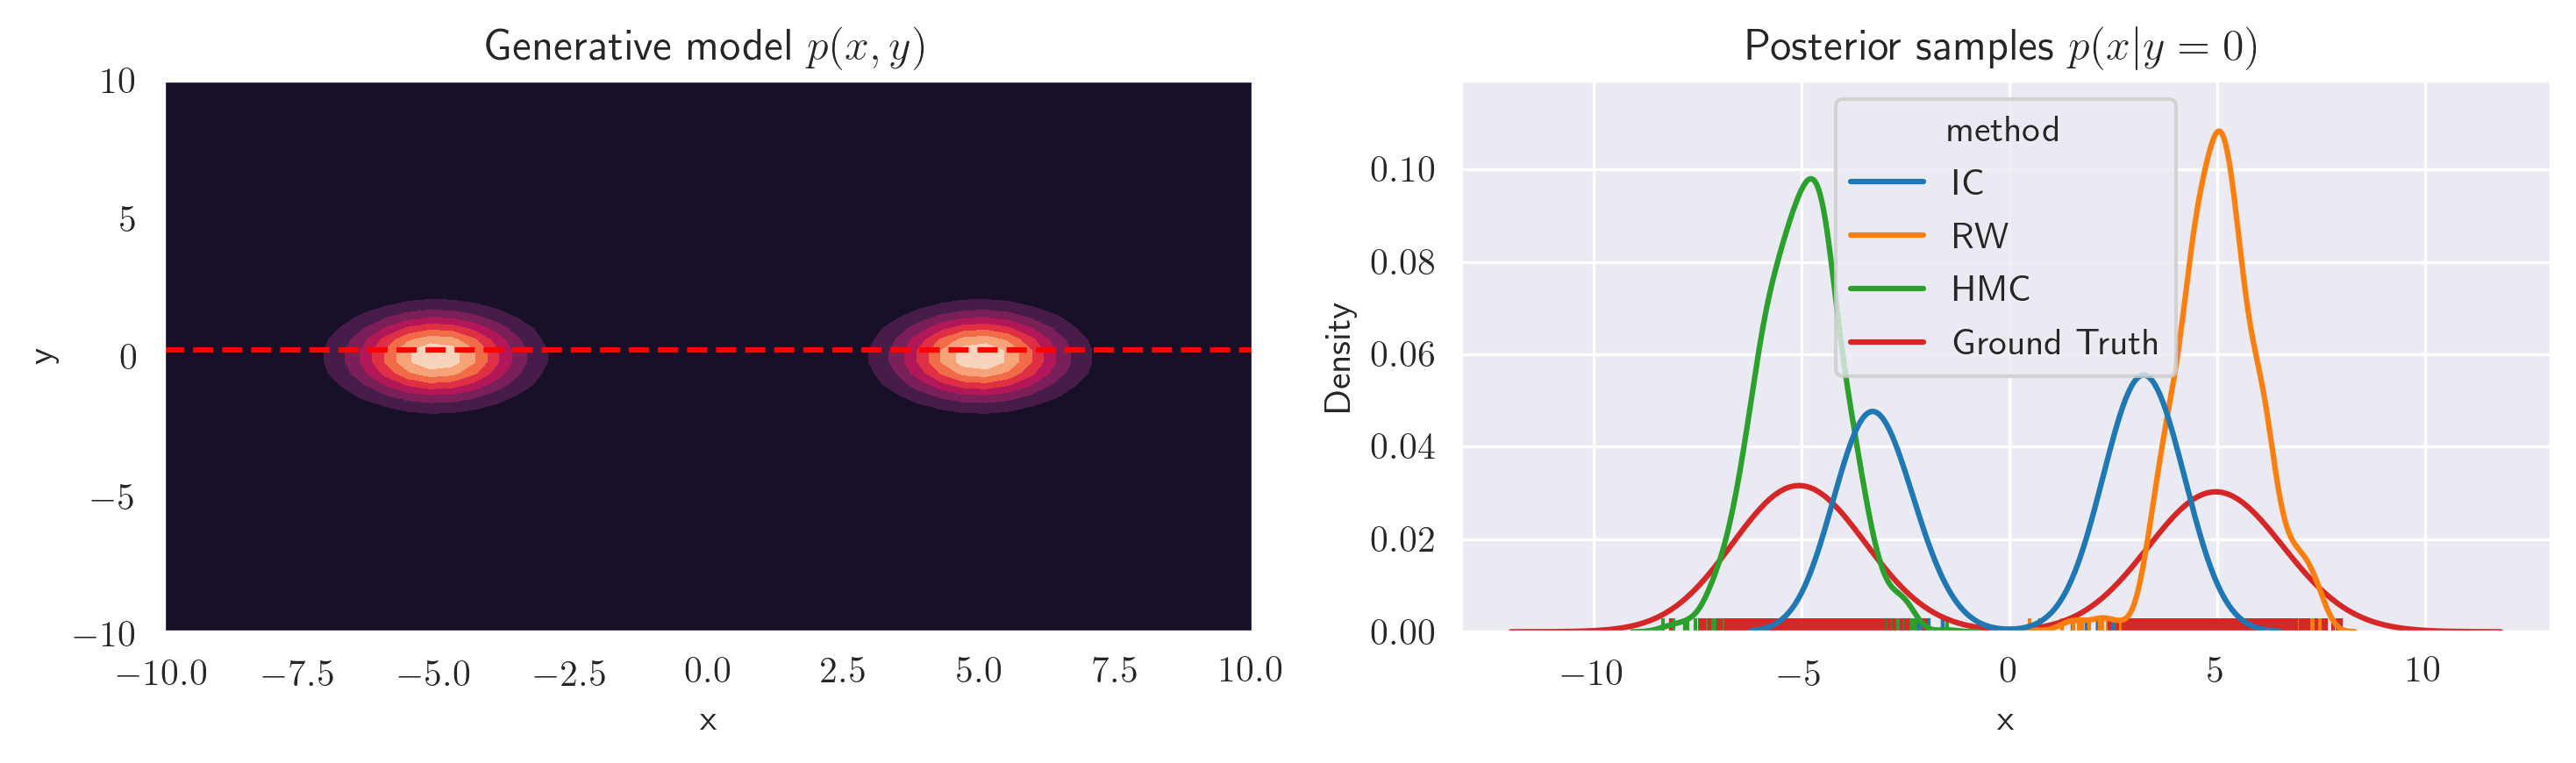

In [110]:
fig, ax = plt.subplots(1,2,figsize=(10,3),dpi=300)

fig.tight_layout()
plt.savefig('intuition.pdf')

ax[0].contourf(x,y,z)
ax[0].axhline(y=0.25, c='r', linestyle='--')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title(r'Generative model $p(x,y)$')


g = sns.kdeplot(data=df, x='x', hue='method', bw_adjust=1, ax=ax[1])
g = sns.rugplot(data=df, x='x', hue='method', ax=ax[1])
g.set(title=r"Posterior samples $p(x|y=0)$")

fig.tight_layout()
fig.savefig('intuition.pdf')